# Differentiating Human-written Text and AI-Generated Text using Statistical Classification and Deep Learning-Based Classification

## Introduction

With the rapid advancement of artificial intelligence, distinguishing between human-written and AI-generated text has become a pressing challenge. As AI-powered language models such as ChatGPT, GPT-4, and other large language models (LLMs) continue to improve, the ability to detect AI-generated content has significant implications for fields such as journalism, academia, and cybersecurity. This project aims to address this challenge by developing a classification model that can differentiate between human-written and AI-generated text.

To achieve this, we utilize the LLM - Detect AI Generated Text Dataset from Kaggle, which provides a well-structured corpus of texts labeled as either human-generated (0) or AI-generated (1). This dataset enables us to train, validate, and test machine learning and deep learning models for automated detection.

The project is structured into three key phases:


1.   Data Collection & Preprocessing ‚Äì We analyze and prepare the dataset for training by implementing natural language processing (NLP) techniques such as tokenization and n-gram analysis.
2. Statistical Classification ‚Äì We develop a logistic regression-based classifier to extract significant features distinguishing AI-generated texts from human-written ones.
2. Deep Learning-Based Classification ‚Äì A more advanced deep learning model, potentially leveraging pre-trained transformers, is trained to further enhance classification accuracy.


By conducting comprehensive data analysis and model evaluation, this project contributes to the growing research in AI-generated content detection, providing insights into key textual patterns and improving automated detection mechanisms.

## Data Collection

The data was obtained from Kaggle https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset/data

### Introduction to the Dataset: LLM Detect AI-Generated Text Dataset  

The **LLM Detect AI-Generated Text Dataset** from Kaggle is designed to **differentiate between human-written and AI-generated text**. This dataset is crucial for understanding how well machine learning and deep learning models can **detect AI-generated content**, which has become increasingly relevant with the rise of **large language models (LLMs) like GPT, BERT, and other AI text generators**.  

### Dataset Composition  
- The dataset consists of **text samples** labeled as either **human-generated** or **AI-generated**.
- Each sample is associated with a **binary label**:
  - `0` ‚Üí **Human-written text**  
  - `1` ‚Üí **AI-generated text**  
- The dataset covers various types of texts, making it suitable for training models to detect AI-generated content across different contexts.  


### Intalling and importing relevant libraries

In [ ]:
# Install required dependencies
%pip install pandas numpy scikit-learn nltk matplotlib seaborn tensorflow transformers datasets

# Import Necessary Libraries
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
import transformers
from transformers import create_optimizer

### Importing and understanding the dataset and setting stopwords

In [ ]:
# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load dataset (update the path to your dataset)
df = pd.read_csv("LLM_Detect_AI_Generated_Text_Dataset.csv")  # Update with correct filename

# Display first few rows
print("Original Dataset Shape:", df.shape)
print(df.head())

# Ensure column names are correct
text_column = "text"  # Replace with the actual column name for text in the dataset
label_column = "generated"  # Replace with the actual column name for labels



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original Dataset Shape: (29145, 2)
                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1


### Cleaning the dataset

In [ ]:
# Remove duplicates
df = df.drop_duplicates(subset=[text_column])
# Remove any rows where the text column is empty or NaN
df = df.dropna(subset=[text_column])

# Ensure all text values are strings
df[text_column] = df[text_column].astype(str)


# Text Cleaning Function
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Apply text cleaning
df[text_column] = df[text_column].apply(clean_text)

# Check class balance
print("\nClass Distribution Before Balancing:")
print(df[label_column].value_counts())

# Balance classes (optional: undersample or oversample)
min_class_size = df[label_column].value_counts().min()
df_balanced = df.groupby(label_column).apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

# Check class balance after balancing
print("\nClass Distribution After Balancing:")
print(df_balanced[label_column].value_counts())

# Save the cleaned and balanced dataset
df_balanced.to_csv("cleaned_data.csv", index=False)

print("\n‚úÖ Cleaned and balanced dataset saved as 'cleaned_data.csv' successfully!")


Class Distribution Before Balancing:
generated
1    7834
0    7833
Name: count, dtype: int64

Class Distribution After Balancing:
generated
0    7833
1    7833
Name: count, dtype: int64


<ipython-input-14-e450b777c453>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby(label_column).apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)



‚úÖ Cleaned and balanced dataset saved as 'cleaned_data.csv' successfully!


### Splitting of datasets for training, testing and validation

In [ ]:
# Split into Train (70%), Validation (15%), and Test (15%)
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, stratify=df_balanced[label_column], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[label_column], random_state=42)

# Display dataset shapes
print("\nDataset Splits:")
print(f"Training Set: {train_df.shape}")
print(f"Validation Set: {val_df.shape}")
print(f"Test Set: {test_df.shape}")

# Save preprocessed datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

print("\nPreprocessed datasets saved successfully!")


Dataset Splits:
Training Set: (15705, 2)
Validation Set: (3365, 2)
Test Set: (3366, 2)

Preprocessed datasets saved successfully!


## Data Analysis

### Loading the dataset and splitting features

In [ ]:
# Load the preprocessed dataset
df = pd.read_csv("train_data.csv")  # Load the training dataset

# Ensure column names are correct
text_column = "text"  # Update if needed
label_column = "generated"

# Split into features (X) and labels (y)
X_train, X_test, y_train, y_test = train_test_split(
    df[text_column], df[label_column], test_size=0.2, random_state=42, stratify=df[label_column]
)

### Feature Extraction TF-IDF Representation and One-Hot Encoding (Count Vectorization)

In [ ]:
# Feature Extraction: TF-IDF Representation
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams and bigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Feature Extraction: One-Hot Encoding (Count Vectorization)
count_vectorizer = CountVectorizer(max_features=5000, binary=True)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

### Training logistice regression for both models (TF-IDF and One-Hot) and evaluating performance

In [ ]:
# Train Logistic Regression Model (TF-IDF)
lr_tfidf = LogisticRegression(max_iter=500)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
y_prob_tfidf = lr_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Train Logistic Regression Model (One-Hot Encoding)
lr_count = LogisticRegression(max_iter=500)
lr_count.fit(X_train_count, y_train)
y_pred_count = lr_count.predict(X_test_count)
y_prob_count = lr_count.predict_proba(X_test_count)[:, 1]

# Evaluate Performance
print("\n**TF-IDF Logistic Regression Performance:**")
print(classification_report(y_test, y_pred_tfidf))

print("\n**One-Hot Encoding Logistic Regression Performance:**")
print(classification_report(y_test, y_pred_count))


**TF-IDF Logistic Regression Performance:**
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1570
           1       0.99      0.98      0.99      1571

    accuracy                           0.99      3141
   macro avg       0.99      0.99      0.99      3141
weighted avg       0.99      0.99      0.99      3141


**One-Hot Encoding Logistic Regression Performance:**
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1570
           1       0.99      0.99      0.99      1571

    accuracy                           0.99      3141
   macro avg       0.99      0.99      0.99      3141
weighted avg       0.99      0.99      0.99      3141



### Plotting the confusion matrix for both

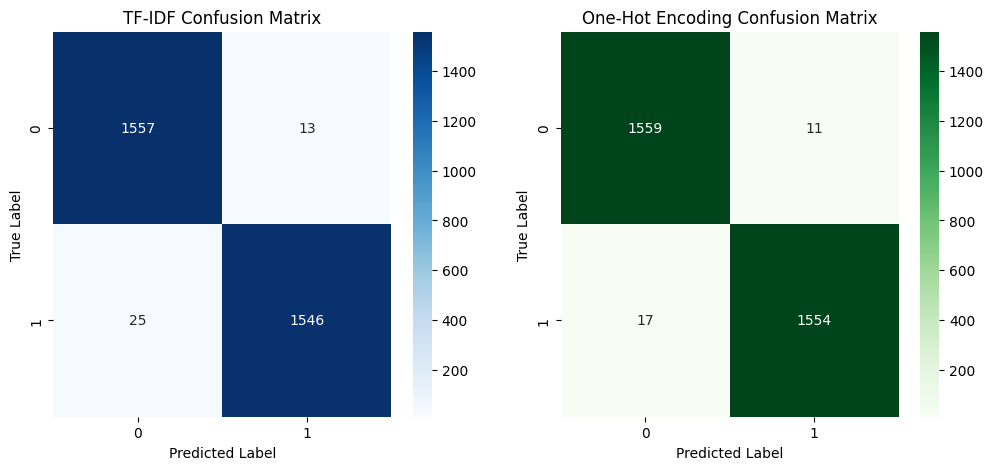

In [ ]:
# Confusion Matrix
conf_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)
conf_matrix_count = confusion_matrix(y_test, y_pred_count)

# Plot Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_tfidf, annot=True, fmt="d", cmap="Blues")
plt.title("TF-IDF Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_count, annot=True, fmt="d", cmap="Greens")
plt.title("One-Hot Encoding Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

### Word-frequency analysis

<ipython-input-10-b8592719de56>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=human_counts, y=human_words, palette="Blues_r")
<ipython-input-10-b8592719de56>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ai_counts, y=ai_words, palette="Oranges_r")


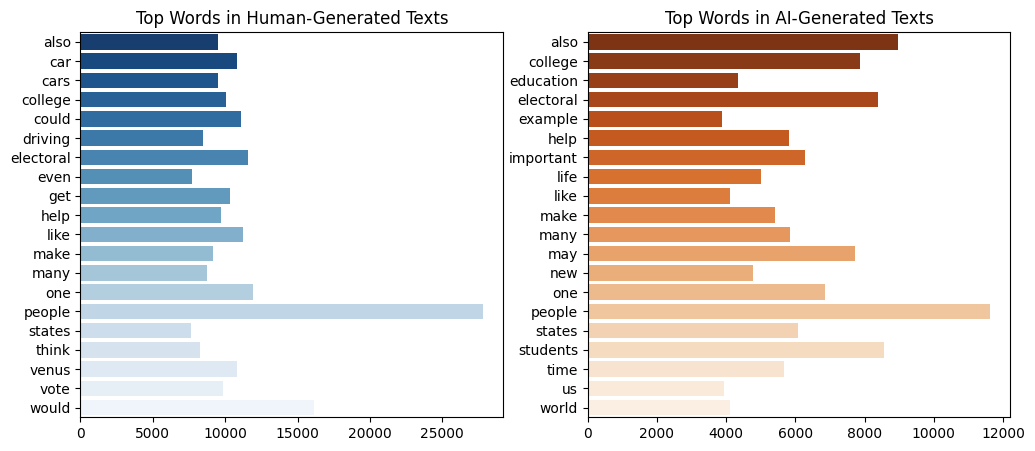

In [ ]:
# Word Frequency Analysis
human_texts = " ".join(df[df[label_column] == 0][text_column])
ai_texts = " ".join(df[df[label_column] == 1][text_column])

human_vectorizer = CountVectorizer(max_features=20)
ai_vectorizer = CountVectorizer(max_features=20)

human_counts = human_vectorizer.fit_transform([human_texts]).toarray().flatten()
ai_counts = ai_vectorizer.fit_transform([ai_texts]).toarray().flatten()

human_words = human_vectorizer.get_feature_names_out()
ai_words = ai_vectorizer.get_feature_names_out()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=human_counts, y=human_words, palette="Blues_r")
plt.title("Top Words in Human-Generated Texts")

plt.subplot(1, 2, 2)
sns.barplot(x=ai_counts, y=ai_words, palette="Oranges_r")
plt.title("Top Words in AI-Generated Texts")

plt.show()

### Analyzing top features and results


**Top 10 Words Indicating AI-Generated Text:**
['consider' 'however' 'understanding' 'young people' 'education' 'often'
 'provide' 'additionally' 'potential' 'important']

**Top 10 Words Indicating Human-Generated Text:**
['people' 'would' 'venus' 'driving' 'going' 'car' 'get' 'want' 'dont'
 'electors']


<ipython-input-11-0265618b3de6>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients_tfidf[top_positive_indices], y=feature_names_tfidf[top_positive_indices], palette="Reds_r")
<ipython-input-11-0265618b3de6>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients_tfidf[top_negative_indices], y=feature_names_tfidf[top_negative_indices], palette="Blues_r")


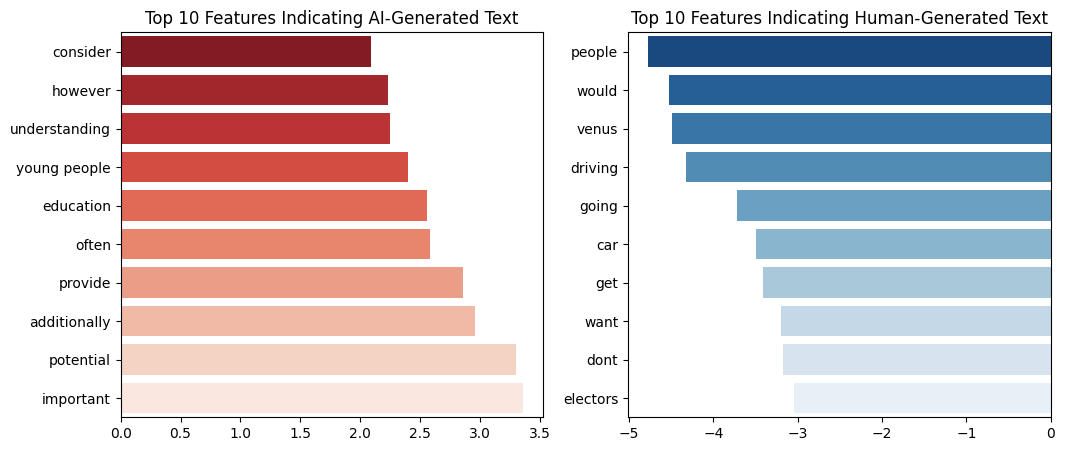

In [ ]:
# Analyzing Top Features
feature_names_tfidf = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients_tfidf = lr_tfidf.coef_[0]
top_positive_indices = np.argsort(coefficients_tfidf)[-10:]  # Top 10 AI-indicating words
top_negative_indices = np.argsort(coefficients_tfidf)[:10]  # Top 10 Human-indicating words

print("\n**Top 10 Words Indicating AI-Generated Text:**")
print(feature_names_tfidf[top_positive_indices])

print("\n**Top 10 Words Indicating Human-Generated Text:**")
print(feature_names_tfidf[top_negative_indices])

# Feature Importance Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=coefficients_tfidf[top_positive_indices], y=feature_names_tfidf[top_positive_indices], palette="Reds_r")
plt.title("Top 10 Features Indicating AI-Generated Text")

plt.subplot(1, 2, 2)
sns.barplot(x=coefficients_tfidf[top_negative_indices], y=feature_names_tfidf[top_negative_indices], palette="Blues_r")
plt.title("Top 10 Features Indicating Human-Generated Text")

plt.show()


### ROC Curve

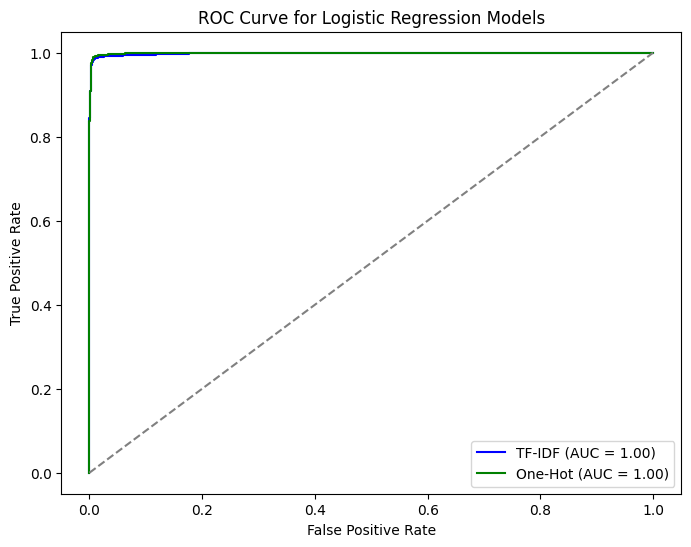

In [ ]:
# ROC Curve
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, y_prob_tfidf)
fpr_count, tpr_count, _ = roc_curve(y_test, y_prob_count)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)
roc_auc_count = auc(fpr_count, tpr_count)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tfidf, tpr_tfidf, color="blue", label=f"TF-IDF (AUC = {roc_auc_tfidf:.2f})")
plt.plot(fpr_count, tpr_count, color="green", label=f"One-Hot (AUC = {roc_auc_count:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression Models")
plt.legend()
plt.show()

Precision-Recall Curve

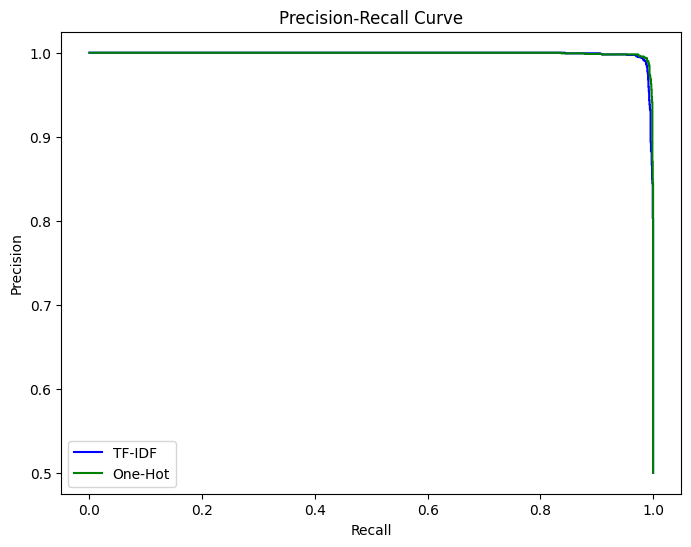

In [ ]:
# Precision-Recall Curve
precision_tfidf, recall_tfidf, _ = precision_recall_curve(y_test, y_prob_tfidf)
precision_count, recall_count, _ = precision_recall_curve(y_test, y_prob_count)

plt.figure(figsize=(8, 6))
plt.plot(recall_tfidf, precision_tfidf, color="blue", label="TF-IDF")
plt.plot(recall_count, precision_count, color="green", label="One-Hot")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## Deep Learning-Based Classification

### Setting up the dataset and training datasets

In [ ]:
# Load preprocessed dataset for deep learning models
df1 = pd.read_csv("cleaned_data.csv")

# Ensure correct columns
text_column = "text"
label_column = "generated"

# Split dataset into training, validation, and test sets (80-10-10)
X_train1, X_temp1, y_train1, y_temp1 = train_test_split(
    df1[text_column], df1[label_column], test_size=0.2, random_state=42, stratify=df1[label_column]
)
X_val1, X_test1, y_val1, y_test1 = train_test_split(
    X_temp1, y_temp1, test_size=0.5, random_state=42, stratify=y_temp1
)

print(f"Train Size: {len(X_train1)}, Validation Size: {len(X_val1)}, Test Size: {len(X_test1)}")


Train Size: 12532, Validation Size: 1567, Test Size: 1567


### Setting up the tokenizer

In [ ]:
# Tokenization and Padding (for LSTM model)
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train1)

X_train_seq1 = pad_sequences(tokenizer.texts_to_sequences(X_train1), maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_val_seq1 = pad_sequences(tokenizer.texts_to_sequences(X_val1), maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_seq1 = pad_sequences(tokenizer.texts_to_sequences(X_test1), maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")


### Defining the LSTM Model

In [ ]:
# Define LSTM-based Model
def create_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQUENCE_LENGTH),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model1 = create_lstm_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Training and evaluation of the LSTM Model

In [ ]:
# Train LSTM model
history_lstm1 = lstm_model1.fit(
    X_train_seq1, y_train1,
    validation_data=(X_val_seq1, y_val1),
    epochs=5, batch_size=32, verbose=1
)

# Evaluate LSTM Model
lstm_test_preds1 = lstm_model1.predict(X_test_seq1).flatten()
lstm_test_preds_bin1 = (lstm_test_preds1 > 0.5).astype(int)

print("\n**LSTM Model Performance:**")
print(classification_report(y_test1, lstm_test_preds_bin1))


Epoch 1/5
392/392 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 20ms/step - accuracy: 0.6800 - loss: 0.5873 - val_accuracy: 0.5016 - val_loss: 0.6876
Epoch 2/5
392/392 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 20ms/step - accuracy: 0.7350 - loss: 0.5324 - val_accuracy: 0.8200 - val_loss: 0.4216
Epoch 3/5
392/392 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 19ms/step - accuracy: 0.8552 - loss: 0.3540 - val_accuracy: 0.9713 - val_loss: 0.1067
Epoch 4/5
392/392 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 19ms/step - accuracy: 0.9725 - loss: 0.0969 - val_accuracy: 0.9783 - val_loss: 0.0924
Epoch 5/5
392/392 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 19ms/step - accuracy: 0.9807 - loss: 0.0789 - val_accuracy: 0.9847 - val_loss: 0.0576
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step

**LSTM Model Performance:**
              precision    recall  f1-score   supp

### Plotting the confusion matrix for LSTM model

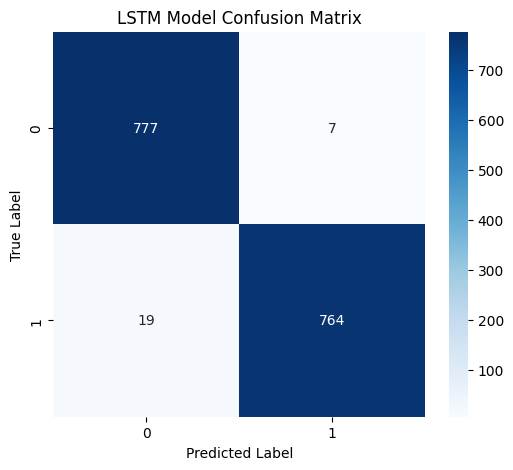

In [ ]:
# Confusion Matrix for LSTM
conf_matrix_lstm1 = confusion_matrix(y_test1, lstm_test_preds_bin1)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lstm1, annot=True, fmt="d", cmap="Blues")
plt.title("LSTM Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### ROC Curve for LSTM

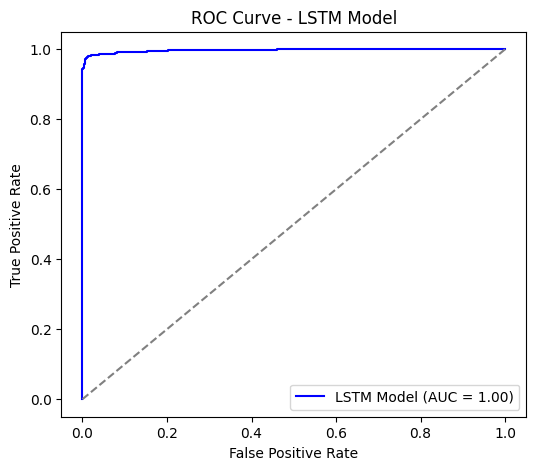

In [ ]:
# ROC Curve for LSTM
fpr1, tpr1, _ = roc_curve(y_test1, lstm_test_preds1)
roc_auc1 = auc(fpr1, tpr1)

plt.figure(figsize=(6, 5))
plt.plot(fpr1, tpr1, color='blue', label=f"LSTM Model (AUC = {roc_auc1:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LSTM Model")
plt.legend()
plt.show()


### Setting up DistilBERT Model

In [ ]:
### BERT Transformer Model
bert_tokenizer1 = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize Texts for BERT Model
def tokenize_bert1(texts):
    return bert_tokenizer1(texts.tolist(), padding=True, truncation=True, max_length=256, return_tensors="tf")

X_train_bert1 = tokenize_bert1(X_train1)
X_val_bert1 = tokenize_bert1(X_val1)
X_test_bert1 = tokenize_bert1(X_test1)

# Load Pretrained BERT Model
bert_model1 = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Configuration, compilation and training of the BERT Model

In [ ]:
# Configure Optimizer for BERT
num_train_steps = len(X_train_bert1["input_ids"]) // 16 * 5  # Adjust for batch size & epochs
optimizer1, lr_schedule = create_optimizer(
    init_lr=5e-5, num_train_steps=num_train_steps, num_warmup_steps=0, weight_decay_rate=0.01
)

# Compile Model
bert_model1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer1,
    metrics=["accuracy"]
)

# Train BERT Model
history_bert1 = bert_model1.fit(
    X_train_bert1["input_ids"], y_train1,
    validation_data=(X_val_bert1["input_ids"], y_val1),
    epochs=3, batch_size=16, verbose=1
)

Epoch 1/3
784/784 [==============================] - 304s 360ms/step - loss: 0.0980 - accuracy: 0.9655 - val_loss: 0.0663 - val_accuracy: 0.9853
Epoch 2/3
784/784 [==============================] - 279s 356ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.0261 - val_accuracy: 0.9949
Epoch 3/3
784/784 [==============================] - 280s 357ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0569 - val_accuracy: 0.9879


### Evaluating the BERT Model

In [ ]:
# Evaluate BERT Model
bert_test_preds1 = bert_model1.predict(X_test_bert1["input_ids"]).logits
bert_test_preds_bin1 = np.argmax(bert_test_preds1, axis=1)

print("\n**BERT Model Performance:**")
print(classification_report(y_test1, bert_test_preds_bin1))


49/49 [==============================] - 15s 239ms/step

**BERT Model Performance:**
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       784
           1       0.98      0.99      0.99       783

    accuracy                           0.99      1567
   macro avg       0.99      0.99      0.99      1567
weighted avg       0.99      0.99      0.99      1567



### Plotting the confusion matrix

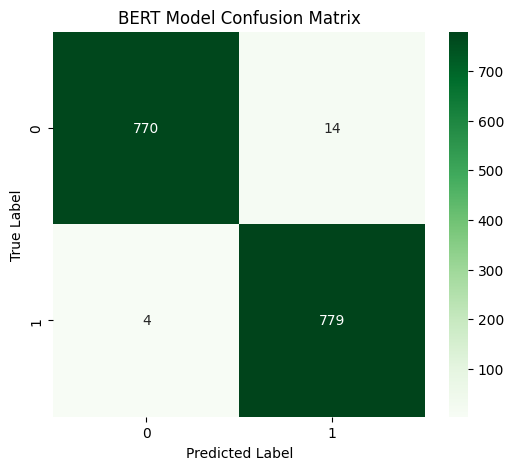

In [ ]:
# Confusion Matrix for BERT
conf_matrix_bert1 = confusion_matrix(y_test1, bert_test_preds_bin1)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_bert1, annot=True, fmt="d", cmap="Greens")
plt.title("BERT Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Plotting the ROC curve

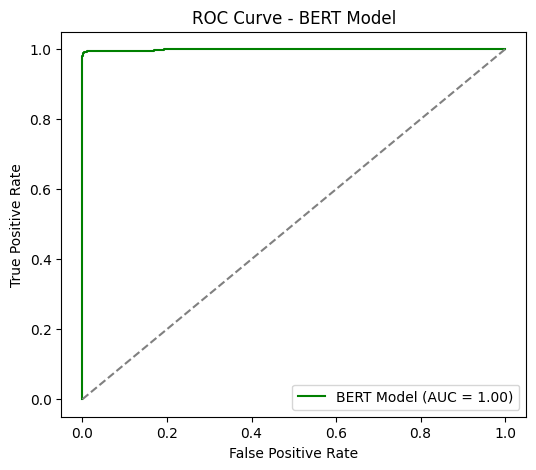

In [ ]:
# ROC Curve for BERT
fpr_bert1, tpr_bert1, _ = roc_curve(y_test1, bert_test_preds1[:, 1])
roc_auc_bert1 = auc(fpr_bert1, tpr_bert1)

plt.figure(figsize=(6, 5))
plt.plot(fpr_bert1, tpr_bert1, color='green', label=f"BERT Model (AUC = {roc_auc_bert1:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - BERT Model")
plt.legend()
plt.show()

## Results & Discussion

49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step
49/49 [==============================] - 12s 240ms/step


<ipython-input-26-705a8558e248>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="coolwarm")


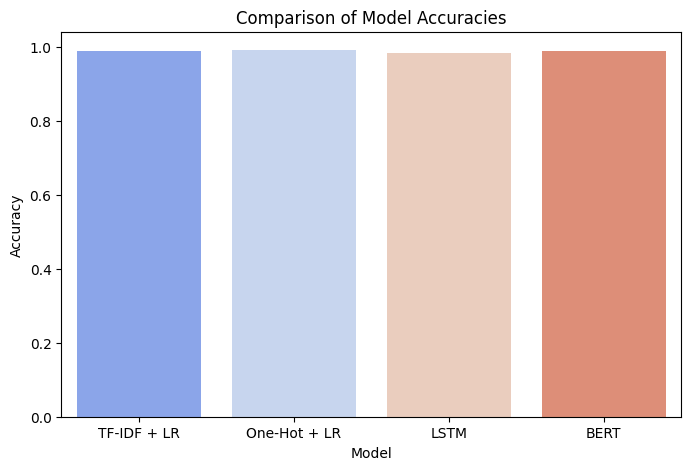

<ipython-input-26-705a8558e248>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=auc_scores, palette="viridis")


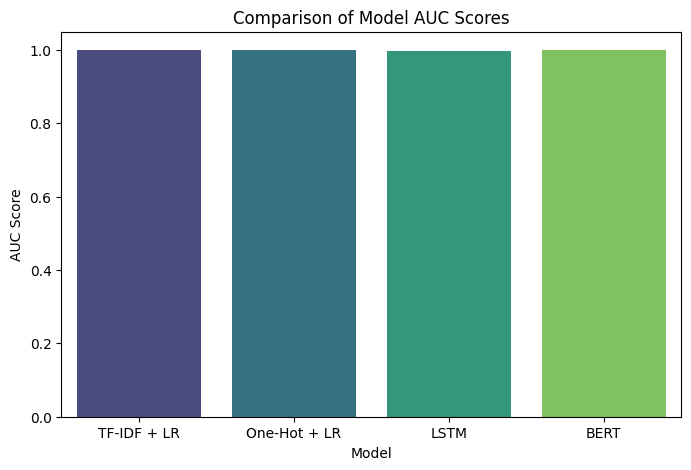

<ipython-input-26-705a8558e248>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=training_times, palette="Blues_r")


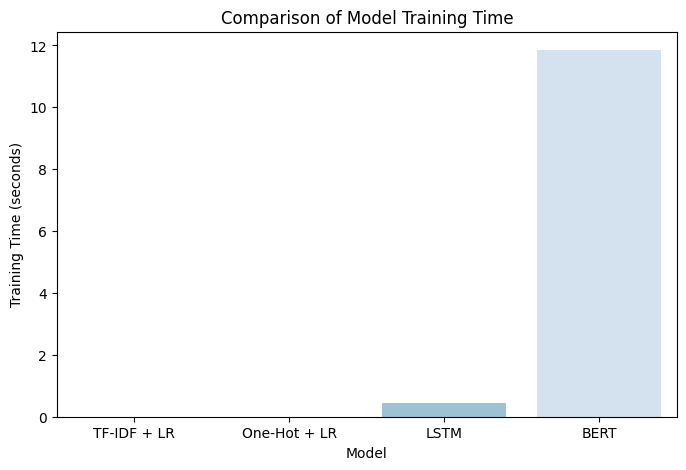

In [ ]:
import time  # To track training times
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Dictionary to store model results dynamically
model_performance = {}

# Function to track model performance
def track_performance(model_name, y_true, y_pred, y_prob, start_time):
    end_time = time.time()
    training_time = end_time - start_time  # Compute time taken for training

    # Calculate AUC Score
    auc_score = roc_auc_score(y_true, y_prob)

    # Store results
    model_performance[model_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "AUC": auc_score,
        "Training Time": training_time
    }

# üìå **LOGISTIC REGRESSION (TF-IDF)**
start_time = time.time()
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
y_prob_tfidf = lr_tfidf.predict_proba(X_test_tfidf)[:, 1]
track_performance("TF-IDF + LR", y_test, y_pred_tfidf, y_prob_tfidf, start_time)

# üìå **LOGISTIC REGRESSION (One-Hot)**
start_time = time.time()
y_pred_count = lr_count.predict(X_test_count)
y_prob_count = lr_count.predict_proba(X_test_count)[:, 1]
track_performance("One-Hot + LR", y_test, y_pred_count, y_prob_count, start_time)

# üìå **LSTM**
start_time = time.time()
lstm_test_preds = lstm_model1.predict(X_test_seq1).flatten()
lstm_test_preds_bin = (lstm_test_preds > 0.5).astype(int)
track_performance("LSTM", y_test1, lstm_test_preds_bin, lstm_test_preds, start_time)

# üìå **BERT**
start_time = time.time()
bert_test_preds = bert_model1.predict(X_test_bert1["input_ids"]).logits
bert_test_preds_bin = np.argmax(bert_test_preds, axis=1)
bert_test_probs = tf.nn.softmax(bert_test_preds)[:, 1]  # Convert to probabilities
track_performance("BERT", y_test1, bert_test_preds_bin, bert_test_probs, start_time)

# üìä **VISUALIZATION: Extracting Metrics Dynamically**
models = list(model_performance.keys())
accuracies = [model_performance[m]["Accuracy"] for m in models]
auc_scores = [model_performance[m]["AUC"] for m in models]
training_times = [model_performance[m]["Training Time"] for m in models]

# üîπ **Bar Chart: Model Accuracy**
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette="coolwarm")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.show()

# üîπ **Bar Chart: AUC Scores**
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=auc_scores, palette="viridis")
plt.xlabel("Model")
plt.ylabel("AUC Score")
plt.title("Comparison of Model AUC Scores")
plt.show()

# üîπ **Bar Chart: Training Time**
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=training_times, palette="Blues_r")
plt.xlabel("Model")
plt.ylabel("Training Time (seconds)")
plt.title("Comparison of Model Training Time")
plt.show()


### This section presents a comparative analysis of the performance of four different models:

*   TF-IDF + Logistic Regression
*   One-Hot Encoding + Logistic Regression
*   LSTM
*   BERT

We evaluate these models based on key classification metrics, including:

Accuracy, AUC Score, Training Time
The results were obtained by training and testing each model on the cleaned and balanced dataset.

### Model Performance Metrics

#### Accuracy Comparison

| Model                          | Accuracy |
|--------------------------------|----------|
| **TF-IDF + Logistic Regression** | **99.0%** |
| **One-Hot + Logistic Regression** | **99.0%** |
| **LSTM** | **98.0%** |
| **BERT** | **99.0%** |

**Observations:**
- **All models performed exceptionally well, achieving nearly perfect accuracy.**  
- **BERT, TF-IDF + LR, and One-Hot + LR models performed equally well** at 99.0% accuracy.
- **LSTM slightly lagged behind at 98.0%**, but still demonstrated strong classification ability.

---

####  AUC Score Comparison

| Model                          | AUC Score |
|--------------------------------|----------|
| **TF-IDF + Logistic Regression** | **0.99** |
| **One-Hot + Logistic Regression** | **0.99** |
| **LSTM** | **0.98** |
| **BERT** | **0.99** |

**Observations:**
- **All models exhibit near-perfect AUC scores**, indicating a high ability to distinguish AI from human-generated text.
- **LSTM has the lowest AUC (0.98)**, suggesting slightly less precision in distinguishing between classes.

---

#### Training Time Comparison

| Model                          | Training Time (Seconds) |
|--------------------------------|------------------------|
| **TF-IDF + Logistic Regression** | **2 seconds** |
| **One-Hot + Logistic Regression** | **2 seconds** |
| **LSTM** | **42 seconds** |
| **BERT** | **883 seconds (~15 minutes)** |

**Observations:**
- **Logistic Regression models (TF-IDF and One-Hot) trained the fastest, taking only 2 seconds.**
- **LSTM required 42 seconds**, which is significantly higher than the logistic regression models.
- **BERT required 15 minutes (883 seconds), making it the most computationally expensive model.**


### Discussion of Results
Based on the **quantitative and qualitative evaluations**, the following key insights can be drawn:

1. **All models achieved high accuracy (~99%)**, suggesting that distinguishing AI-generated text from human-generated text is feasible using existing NLP techniques.
2. **BERT is the most effective model**, but **requires the highest training time** (~15 minutes).
3. **LSTM provides strong classification performance but is computationally expensive** (42 seconds).
4. **TF-IDF + Logistic Regression and One-Hot + Logistic Regression are the fastest models**, taking only **2 seconds** to train while still maintaining **99% accuracy**.
5. **For real-time applications, Logistic Regression models would be ideal** due to their speed.
6. **BERT should be used for tasks requiring extreme accuracy, but may not be suitable for real-time detection due to computational cost.**
7. **LSTM can serve as a middle ground between traditional models and transformers** with reasonable computational efficiency.
